# Tab Transf

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, einsum
from einops import rearrange
from tqdm import tqdm
# helpers

def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


# classes

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


# attention

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)


class FeedForward(nn.Module):
    def __init__(self, dim, mult=4, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x, **kwargs):
        return self.net(x)


class Attention(nn.Module):
    def __init__(
            self,
            dim,
            heads=8,
            dim_head=16,
            dropout=0.
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), (q, k, v))
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = sim.softmax(dim=-1)
        attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h=h)
        return self.to_out(out)


# transformer

class Transformer(nn.Module):
    def __init__(self, num_tokens, dim, depth, heads, dim_head, attn_dropout, ff_dropout):
        super().__init__()
        self.embeds = nn.Embedding(num_tokens, dim)     # all number of tokens to hidd dim
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=attn_dropout))),
                Residual(PreNorm(dim, FeedForward(dim, dropout=ff_dropout))),
            ]))

    def forward(self, x):
        x = self.embeds(x)

        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)

        return x


# mlp

class MLP(nn.Module):
    def __init__(self, dims, act=None):
        super().__init__()
        dims_pairs = list(zip(dims[:-1], dims[1:]))
        layers = []
        for ind, (dim_in, dim_out) in enumerate(dims_pairs):
            is_last = ind >= (len(dims_pairs) - 1)
            linear = nn.Linear(dim_in, dim_out)
            layers.append(linear)

            # removed last layer to get logits
            # if is_last:
            #     continue
            # act = default(act, nn.ReLU())
            # layers.append(act)

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


# main class

class TabTransformer(nn.Module):
    def __init__(
            self,
            *,
            categories,
            num_continuous,
            dim,
            depth,
            heads,
            dim_head=16,
            dim_out=1,
            mlp_hidden_mults=(4, 2),
            mlp_act=None,
            num_special_tokens=2,
            continuous_mean_std=None,
            attn_dropout=0.,
            ff_dropout=0.,
            seed=42
    ):
        super().__init__()
        assert all(map(lambda n: n > 0, categories)), 'number of each category must be positive'

        self.categories = categories
        torch.manual_seed(seed)

        # categories related calculations

        self.num_categories = len(categories)  # len of input sequences
        self.num_unique_categories = sum(categories)  # number of all categories

        # create category embeddings table

        self.num_special_tokens = num_special_tokens  # for missing?
        total_tokens = self.num_unique_categories + num_special_tokens

        # for automatically offsetting unique category ids to the correct position in the categories embedding table

        categories_offset = F.pad(torch.tensor(list(categories)), (1, 0), value=num_special_tokens)  # ??
        categories_offset = categories_offset.cumsum(dim=-1)[:-1]  # cumulative sum
        # if categ = (2, 3, 2, 3), categories_offset = tensor([0, 2, 5, 7]), bias for column categs
        self.register_buffer('categories_offset', categories_offset)  # save it and use in forward

        # continuous

        if exists(continuous_mean_std):
            assert continuous_mean_std.shape == (num_continuous,
                                                 2), f'continuous_mean_std must have a shape of ({num_continuous}, 2) where the last dimension contains the mean and variance respectively'
        self.register_buffer('continuous_mean_std', continuous_mean_std)

        self.norm = nn.LayerNorm(num_continuous)
        self.num_continuous = num_continuous

        # transformer

        self.transformer = Transformer(
            num_tokens=total_tokens,
            dim=dim,
            depth=depth,
            heads=heads,
            dim_head=dim_head,
            attn_dropout=attn_dropout,
            ff_dropout=ff_dropout
        )

        # mlp to logits

        input_size = (dim * self.num_categories) + num_continuous
        l = input_size // 8

        hidden_dimensions = list(map(lambda t: l * t, mlp_hidden_mults))
        all_dimensions = [input_size, *hidden_dimensions, dim_out]

        self.mlp = MLP(all_dimensions, act=mlp_act)

    def forward(self, x_categ, x_cont):
        assert x_categ.shape[
                   -1] == self.num_categories, f'you must pass in {self.num_categories} values for your categories input'
        x_categ += self.categories_offset    #    TODO

        x = self.transformer(x_categ)

        flat_categ = x.flatten(1)

        assert x_cont.shape[
                   1] == self.num_continuous, f'you must pass in {self.num_continuous} values for your continuous input'

        if exists(self.continuous_mean_std):
            mean, std = self.continuous_mean_std.unbind(dim=-1)  # splits tensor into 2 parts
            x_cont = (x_cont - mean) / std

        normed_cont = self.norm(x_cont)  # norm over all batch

        x = torch.cat((flat_categ, normed_cont), dim=-1)
        return self.mlp(x)

    def naive_recover(self, data_nan, nans_pos, device):
        # now x_categ contains NaNs in its rows
        # our task is to find the most suitable token in the corresponding column tokens
        self.eval()
        recovered_labels = []
        for j in tqdm(range(len(nans_pos))):
            i = nans_pos[j]
            # create tensor with many variants for substitution
            row = np.array([data_nan[j]] * self.categories[i])
            row[:, i] = np.arange(self.categories[i])
            # get contextual embeddings
            x_categ = (torch.LongTensor(row).to(device) + self.categories_offset)    # (N, input)
            with torch.no_grad():
                w_categ = self.transformer(x_categ)    # (N, input, hidden)
            # choose the best
            v = w_categ[:, i]
            w_categ = torch.cat((w_categ[:, :i], w_categ[:, i+1:]), dim=1)
            w_pairs = torch.matmul(w_categ, v.unsqueeze(2)).squeeze(2)    # (N,imp,h)x(N,h,1)=(N,inp,1)->(N,inp)
            losses = -nn.LogSoftmax(dim=1)(w_pairs).sum(dim=1)    # (N)
            recovered_labels.append(torch.argmin(losses).detach().cpu().item())

            # without tensors
            # losses = []
            # for tok in range(self.categories[i]):
            #     row = data_nan[j]
            #     row[i] = tok
            #     x_categ = torch.LongTensor(row).unsqueeze(0) + self.categories_offset
            #     with torch.no_grad():
            #         w_categ = self.transformer(x_categ)
            #     w_pairs = torch.matmul(w_categ[0], w_categ[0, i])     # row TODO: try to delete i-th row
            #     # softmax + NNNL, targets = 1
            #     cur_loss = -nn.LogSoftmax(dim=0)(w_pairs).sum().item()
            #     losses.append(cur_loss)
            #     # print(losses)
            # assert np.argmin(losses) == recovered_labels[-1]

        return np.array(recovered_labels)


# train transf

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import random


def my_train_test_split(X1, X2, y, test_size=0.2, val_size=0.05, random_state=42):
    # X1 - categorical, X2 - continious, y - labels
    assert X1.shape[0] == X2.shape[0] == y.shape[0]
    n1 = int(np.around(test_size * y.shape[0]))
    n2 = int(np.around((val_size + test_size) * y.shape[0]))
    if random_state is not None:
        np.random.seed(random_state)

    idx = np.random.permutation(y.shape[0])

    X1_test = X1[idx][:n1]
    X2_test = X2[idx][:n1]
    y_test = y[idx][:n1]

    X1_val = X1[idx][n1:n2]
    X2_val = X2[idx][n1:n2]
    y_val = y[idx][n1:n2]

    X1_train = X1[idx][n2:]
    X2_train = X2[idx][n2:]
    y_train = y[idx][n2:]

    return X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test


class MyDataset(Dataset):
    def __init__(self, X1, X2, y):
        self.X1 = X1
        self.X2 = X2
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]


def count_acc(y_true, y_pred):
    # x = (torch.round(nn.Sigmoid()(y_pred)) == y_true).sum().float().item() / y_true.shape[0] / y_true.shape[1]
    # y = accuracy_score(torch.round(nn.Sigmoid()(y_pred)).detach().numpy(), y_true.detach().numpy())
    # assert x == y
    return (torch.round(nn.Sigmoid()(y_pred)) == y_true).sum().float().item() / y_true.shape[0]
    # return accuracy_score(torch.round(nn.Sigmoid()(y_pred)).detach().numpy(), y_true.detach().numpy())
    # return x


def count_auc(model, device, *dataloaders):
    y_true, y_pred = [], []
    with torch.no_grad():
        for dataloader in dataloaders:
            for i, (x_categ, x_cont, labels) in enumerate(dataloader):
                x_categ, x_cont, labels = x_categ.long().to(device), x_cont.float().to(device), labels.float().to(
                    device)
                pred = nn.Sigmoid()(model.forward(x_categ, x_cont))
                y_true.extend(list(labels.detach().cpu().numpy()))
                y_pred.extend(list(pred.detach().cpu().numpy()))

    return roc_auc_score(y_true, y_pred)


def count_pres_rec_f1(model, device, *dataloaders):
    y_true, y_pred = [], []
    with torch.no_grad():
        for dataloader in dataloaders:
            for i, (x_categ, x_cont, labels) in enumerate(dataloader):
                x_categ, x_cont, labels = x_categ.long().to(device), x_cont.float().to(device), labels.float().to(
                    device)
                pred = nn.Sigmoid()(model.forward(x_categ, x_cont))
                y_true.extend(list(labels.detach().cpu().numpy()))
                y_pred.extend(list(torch.round(pred).detach().cpu().numpy()))

    return precision_score(y_true, y_pred, zero_division=0), \
           recall_score(y_true, y_pred, zero_division=0), \
           f1_score(y_true, y_pred, zero_division=0)


def single_pass(model, dataloader, loss_func, device, optim=None):
    loss_count, acc_count = 0, 0
    for i, (x_categ, x_cont, labels) in enumerate(dataloader):
        x_categ, x_cont, labels = x_categ.long().to(device), x_cont.float().to(device), labels.float().to(device)
        pred = model.forward(x_categ, x_cont)
        loss = loss_func(pred, labels)
        loss_count += loss.item()
        acc_count += count_acc(labels, pred)
        # roc_auc += roc_auc_score(labels, pred, average='macro')
        if optim is not None:
            loss.backward()
            optim.step()
    return loss_count / len(dataloader), acc_count / len(dataloader)


def plot_results(ax, train_results: list, val_results: list, test_result, label):
    epochs = np.arange(1, len(train_results) + 1)
    ax.plot(epochs, train_results, label='train')
    ax.plot(epochs, val_results, label='validation')
    ax.plot(epochs[-1], test_result,
            marker='o', linestyle='none', label='test')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(label)
    ax.grid(linestyle=':')
    ax.legend()


def train_model(model, loss, optim, epochs, device, dataloaders, single_pass=single_pass):
    dataloader_train, dataloader_val, dataloader_test = dataloaders
    train_loss_all, val_loss_all, train_acc_all, val_acc_all = [], [], [], []
    # training loop
    for epoch in range(epochs):
        # train
        # print('train')
        train_loss, train_acc = single_pass(model, dataloader_train, loss, device, optim)
        # print('val')
        # validation
        with torch.no_grad():
            val_loss, val_acc = single_pass(model, dataloader_val, loss, device)

        print(
            f'epoch {epoch}, train_loss={train_loss}, validation_loss={val_loss}, train_acc={train_acc}, val_acc={val_acc}')

        train_loss_all.append(train_loss)
        val_loss_all.append(val_loss)
        train_acc_all.append(train_acc)
        val_acc_all.append(val_acc)

    # test
    model.eval()
    with torch.no_grad():
        test_loss, test_acc = single_pass(model, dataloader_test, loss, device)
        test_AUC = count_auc(model, device, dataloader_test)
        pres, rec, f1 = count_pres_rec_f1(model, device, dataloader_test)

        print(f'test_loss={test_loss}, test_acc={test_acc}')
        print('test_AUC=', test_AUC)
        print('pres=', pres, 'rec=', rec, 'f1=', f1)
    model.train()
    # print(count_auc(model, device, dataloader_train, dataloader_val, dataloader_test))
    return train_loss_all, val_loss_all, train_acc_all, val_acc_all, test_loss, test_acc, test_AUC


def tab_train(filename, mode='mlm_single', seed=42):  # mlm_single / mlm_different
    if mode == 'ordinary':
        path = os.path.join('/content/drive/MyDrive/HSE/NIR/data/nan_as_categ', filename)
    elif mode == 'naive':
        path = os.path.join('/content/drive/MyDrive/HSE/NIR/data/recovered', f'{filename}_naive')
    elif mode == 'mlm_single':
        path = os.path.join('/content/drive/MyDrive/HSE/NIR/data/recovered', f'{filename}_mlm_single')
    elif mode == 'mlm_different':
        path = os.path.join('/content/drive/MyDrive/HSE/NIR/data/recovered', f'{filename}_mlm_different')

    data_categ = pd.read_csv(os.path.join(path, 'categ.csv')).to_numpy()
    data_cont = pd.read_csv(os.path.join(path, 'cont.csv')).to_numpy()
    data_labels = pd.read_csv(os.path.join(path, 'labels.csv')).to_numpy()
    # print(data_cont.shape)

    X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test = my_train_test_split(data_categ,
                                                                                                       data_cont,
                                                                                                       data_labels,
                                                                                                       test_size=0.2,
                                                                                                       val_size=0.05,
                                                                                                       random_state=seed)

    cont_mean_std = np.array([X2_train.mean(axis=0), X2_train.std(axis=0)]).transpose(1, 0)
    cont_mean_std = torch.Tensor(cont_mean_std)

    categories = tuple(len(np.unique(data_categ[:, i])) for i in range(data_categ.shape[1]))
    # print(categories)
    model = TabTransformer(
        categories=categories,  # tuple containing the number of unique values within each category
        num_continuous=data_cont.shape[-1],  # number of continuous values
        dim=32,  # dimension, paper set at 32
        dim_out=1,  # binary prediction, but could be anything
        depth=6,  # depth, paper recommended 6
        heads=2,  # heads, paper recommends 8
        attn_dropout=0.1,  # post-attention dropout
        ff_dropout=0.1,  # feed forward dropout
        mlp_hidden_mults=(4, 2),  # relative multiples of each hidden dimension of the last mlp to logits
        mlp_act=None,  # activation for final mlp, defaults to relu, but could be anything else (selu etc)
        continuous_mean_std=cont_mean_std,  # (optional) - normalize the continuous values before layer norm
        seed=seed
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    batch_size = 10000
    epochs = 25
    lr = 5*1e-5
    optim = Adam(model.parameters(), lr=lr)
    loss = F.binary_cross_entropy_with_logits

    dataset_train = MyDataset(X1_train, X2_train, y_train)
    dataset_val = MyDataset(X1_val, X2_val, y_val)
    dataset_test = MyDataset(X1_test, X2_test, y_test)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
    dataloader_val = DataLoader(dataset_val, batch_size=64)
    dataloader_test = DataLoader(dataset_test, batch_size=64)
    dataloaders = [dataloader_train, dataloader_val, dataloader_test]

    train_loss_all, val_loss_all, train_acc_all, val_acc_all, test_loss, test_acc, test_AUC = \
        train_model(model, loss, optim, epochs, device, dataloaders)

    return train_loss_all, val_loss_all, train_acc_all, val_acc_all, test_loss, test_acc, test_AUC


def my_subplots(train_loss, val_loss, train_acc, val_acc, test_loss, test_acc):
    _, ax1 = plt.subplots()
    plot_results(ax1, train_loss, val_loss, test_loss, 'Loss')
    _, ax2 = plt.subplots()
    plot_results(ax2, train_acc, val_acc, test_acc, 'Accuracy')
    plt.show()


def main(filename, mode, seed):
    logs = tab_train(filename, mode=mode, seed=seed)
    my_subplots(*logs[:-1])
    return [logs[-1], logs[-2]]    # auc, pres

In [ ]:
dataset='adult'

# MLM_SINGLE 

In [ ]:
metrics = []

epoch 0, train_loss=0.6585445702075958, validation_loss=0.6215043205481309, train_acc=0.6548598612786489, val_acc=0.7354967948717949
epoch 1, train_loss=0.598052129149437, validation_loss=0.5745070347419152, train_acc=0.7529490651387213, val_acc=0.7508814102564103
epoch 2, train_loss=0.554660439491272, validation_loss=0.5443007166569049, train_acc=0.759951025331725, val_acc=0.7516826923076924
epoch 3, train_loss=0.5280586183071136, validation_loss=0.5302435877995614, train_acc=0.7605387213510253, val_acc=0.7516826923076924
epoch 4, train_loss=0.5165992826223373, validation_loss=0.529959825369028, train_acc=0.7605387213510253, val_acc=0.7516826923076924
epoch 5, train_loss=0.5169448405504227, validation_loss=0.5370384515860142, train_acc=0.7605137213510254, val_acc=0.7516826923076924
epoch 6, train_loss=0.523173913359642, validation_loss=0.5453075499106677, train_acc=0.7605137213510254, val_acc=0.7516826923076924
epoch 7, train_loss=0.5273697674274445, validation_loss=0.5452772103823148

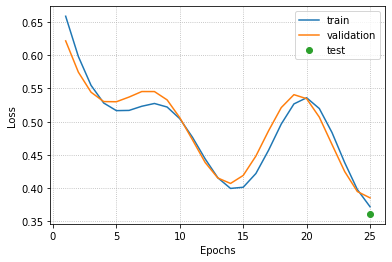

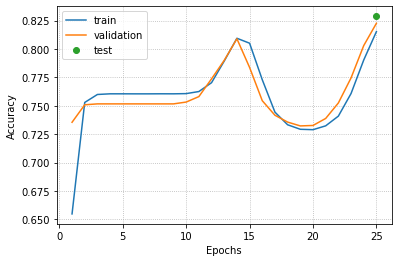

In [ ]:
metrics.append(main(dataset, mode='mlm_single', seed=42))

epoch 0, train_loss=0.6923621147871017, validation_loss=0.6384919667855288, train_acc=0.5174396260554885, val_acc=0.7487179487179487
epoch 1, train_loss=0.6172080934047699, validation_loss=0.5773109136483608, train_acc=0.7542816646562123, val_acc=0.7661057692307692
epoch 2, train_loss=0.5658314824104309, validation_loss=0.5390728872555953, train_acc=0.7591947527141134, val_acc=0.7661057692307692
epoch 3, train_loss=0.53725266456604, validation_loss=0.5228192951434698, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 4, train_loss=0.5304791331291199, validation_loss=0.5263207745857728, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 5, train_loss=0.5405026227235794, validation_loss=0.5423794365846194, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 6, train_loss=0.5591704845428467, validation_loss=0.5609600223027743, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 7, train_loss=0.5758802890777588, validation_loss=0.5711423999223

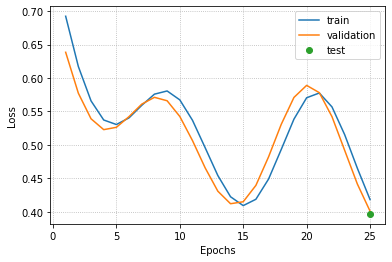

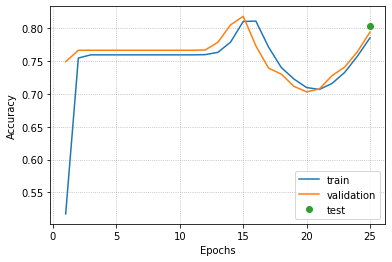

In [ ]:
metrics.append(main(dataset, mode='mlm_single', seed=10))

epoch 0, train_loss=0.6647446006536484, validation_loss=0.6274742835607284, train_acc=0.6777294632086851, val_acc=0.7632211538461539
epoch 1, train_loss=0.6110924184322357, validation_loss=0.5796732833752265, train_acc=0.7590160735826297, val_acc=0.7732371794871795
epoch 2, train_loss=0.5715613067150116, validation_loss=0.5455697239973606, train_acc=0.7615164656212303, val_acc=0.7732371794871795
epoch 3, train_loss=0.5455267578363419, validation_loss=0.5239869891068875, train_acc=0.7615414656212305, val_acc=0.7732371794871795
epoch 4, train_loss=0.5313360840082169, validation_loss=0.5129675162144196, train_acc=0.7615414656212305, val_acc=0.7732371794871795
epoch 5, train_loss=0.5264702588319778, validation_loss=0.5086422979067533, train_acc=0.7615414656212305, val_acc=0.7732371794871795
epoch 6, train_loss=0.5265324711799622, validation_loss=0.5071611224840848, train_acc=0.7615414656212305, val_acc=0.7732371794871795
epoch 7, train_loss=0.5270787924528122, validation_loss=0.50408080564

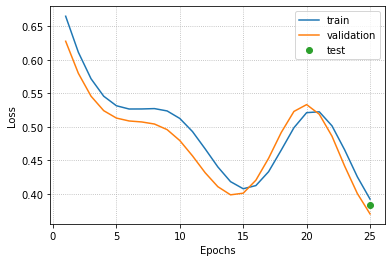

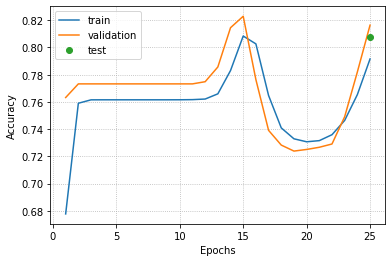

In [ ]:
metrics.append(main(dataset, mode='mlm_single', seed=100))

epoch 0, train_loss=0.6399440318346024, validation_loss=0.606610160607558, train_acc=0.7004431845597104, val_acc=0.7514423076923077
epoch 1, train_loss=0.5821727067232132, validation_loss=0.5640537715875186, train_acc=0.761266857659831, val_acc=0.7546474358974359
epoch 2, train_loss=0.5463390350341797, validation_loss=0.5430138057623154, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 3, train_loss=0.5295818448066711, validation_loss=0.5388888747264178, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 4, train_loss=0.5282625108957291, validation_loss=0.5451266918426905, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 5, train_loss=0.5350282490253448, validation_loss=0.553231587776771, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 6, train_loss=0.5396161824464798, validation_loss=0.5529978840779035, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 7, train_loss=0.5342234224081039, validation_loss=0.53818482236984

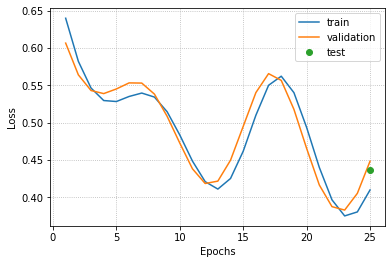

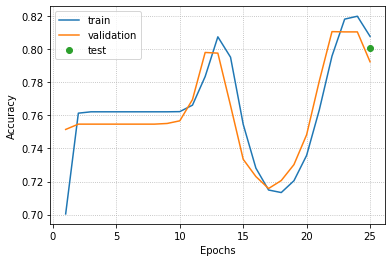

In [ ]:
metrics.append(main(dataset, mode='mlm_single', seed=1000))

epoch 0, train_loss=0.7236628532409668, validation_loss=0.6668407718340555, train_acc=0.4040456272617612, val_acc=0.6197115384615385
epoch 1, train_loss=0.6367960274219513, validation_loss=0.5970536470413208, train_acc=0.7120363691194209, val_acc=0.7510416666666666
epoch 2, train_loss=0.5730107575654984, validation_loss=0.550201993722182, train_acc=0.7627974969843184, val_acc=0.7534455128205128
epoch 3, train_loss=0.5323270559310913, validation_loss=0.5261984536280999, train_acc=0.7619224969843185, val_acc=0.7530448717948718
epoch 4, train_loss=0.5148879140615463, validation_loss=0.5240343320064056, train_acc=0.7616724969843185, val_acc=0.7530448717948718
epoch 5, train_loss=0.5180580466985703, validation_loss=0.53884740288441, train_acc=0.7615974969843184, val_acc=0.7530448717948718
epoch 6, train_loss=0.5359703004360199, validation_loss=0.5639999440083137, train_acc=0.7615974969843184, val_acc=0.7530448717948718
epoch 7, train_loss=0.5587991029024124, validation_loss=0.58540006249378

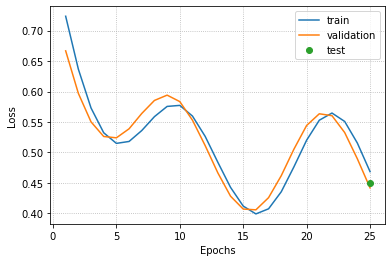

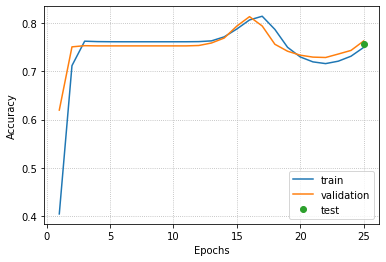

In [ ]:
metrics.append(main(dataset, mode='mlm_single', seed=10000))

In [ ]:
print(metrics)

[[0.8739932909802604, 0.8287990196078432], [0.8680558933484271, 0.8035130718954249], [0.865411120000782, 0.8079656862745098], [0.8768623193360169, 0.8006740196078431], [0.860699009865157, 0.7575163398692811]]


In [ ]:
auc = np.array(metrics)[:, 0]
pres = np.array(metrics)[:, 1]
print('auc', np.mean(auc), np.std(auc))
print('pres', np.mean(pres), np.std(pres))

auc 0.8690043267061288 0.005821112622003051
pres 0.7996936274509804 0.023280995348908515


# MLM_DIFFERENT

In [ ]:
metrics = []

epoch 0, train_loss=0.6476727873086929, validation_loss=0.6117897568604885, train_acc=0.6996621531966224, val_acc=0.7475160256410256
epoch 1, train_loss=0.5872460752725601, validation_loss=0.5661419217403119, train_acc=0.7608518094089264, val_acc=0.7516826923076924
epoch 2, train_loss=0.5454629510641098, validation_loss=0.5378635059564542, train_acc=0.7605387213510253, val_acc=0.7516826923076924
epoch 3, train_loss=0.5218437910079956, validation_loss=0.5282814051860418, train_acc=0.7605137213510254, val_acc=0.7516826923076924
epoch 4, train_loss=0.5151734948158264, validation_loss=0.5330535051150199, train_acc=0.7605137213510254, val_acc=0.7516826923076924
epoch 5, train_loss=0.5218406319618225, validation_loss=0.5480926648164407, train_acc=0.7605137213510254, val_acc=0.7516826923076924
epoch 6, train_loss=0.534524142742157, validation_loss=0.5619135521925412, train_acc=0.7605137213510254, val_acc=0.7516826923076924
epoch 7, train_loss=0.5447850823402405, validation_loss=0.568275816165

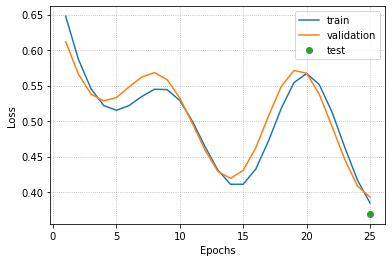

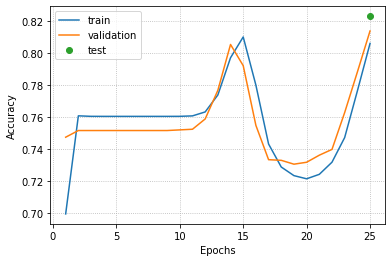

In [ ]:
metrics.append(main(dataset, mode='mlm_different', seed=42))

epoch 0, train_loss=0.6102219372987747, validation_loss=0.57618726675327, train_acc=0.7438011761158023, val_acc=0.7649038461538462
epoch 1, train_loss=0.5647328048944473, validation_loss=0.540546083297485, train_acc=0.7581316646562123, val_acc=0.7661057692307692
epoch 2, train_loss=0.5369053184986115, validation_loss=0.5220459539156693, train_acc=0.7589570566948131, val_acc=0.7661057692307692
epoch 3, train_loss=0.5247727334499359, validation_loss=0.5162956179716648, train_acc=0.7590697527141134, val_acc=0.7661057692307692
epoch 4, train_loss=0.523789182305336, validation_loss=0.5192881440505003, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 5, train_loss=0.5261252373456955, validation_loss=0.5194702652784494, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 6, train_loss=0.5223801732063293, validation_loss=0.5088750269168463, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 7, train_loss=0.5061065107584, validation_loss=0.4863659342130025, 

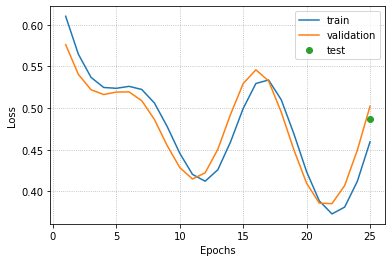

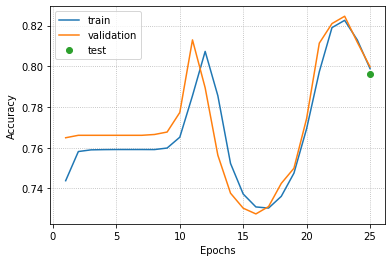

In [ ]:
metrics.append(main(dataset, mode='mlm_different', seed=10))

epoch 0, train_loss=0.648332804441452, validation_loss=0.6076515026581593, train_acc=0.691449457177322, val_acc=0.7745192307692308
epoch 1, train_loss=0.590894028544426, validation_loss=0.5567898245958182, train_acc=0.7683342581423401, val_acc=0.7752403846153846
epoch 2, train_loss=0.5476945489645004, validation_loss=0.5199795411183283, train_acc=0.76262876960193, val_acc=0.7732371794871795
epoch 3, train_loss=0.5191217809915543, validation_loss=0.49748462973496854, train_acc=0.7615164656212303, val_acc=0.7732371794871795
epoch 4, train_loss=0.5049329176545143, validation_loss=0.4880500397621057, train_acc=0.7614914656212304, val_acc=0.7732371794871795
epoch 5, train_loss=0.5036866143345833, validation_loss=0.4905093973263716, train_acc=0.7615414656212305, val_acc=0.7732371794871795
epoch 6, train_loss=0.5116939842700958, validation_loss=0.49934443258322203, train_acc=0.7615414656212305, val_acc=0.7732371794871795
epoch 7, train_loss=0.5240359157323837, validation_loss=0.50850229118114

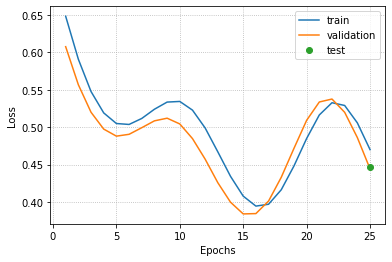

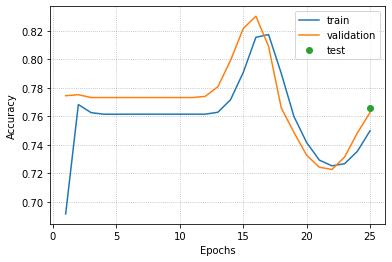

In [ ]:
metrics.append(main(dataset, mode='mlm_different', seed=100))

epoch 0, train_loss=0.6351044774055481, validation_loss=0.6058647984113449, train_acc=0.7356201447527141, val_acc=0.7530448717948718
epoch 1, train_loss=0.5869320929050446, validation_loss=0.5669017961392036, train_acc=0.7613795536791315, val_acc=0.7546474358974359
epoch 2, train_loss=0.5509375780820847, validation_loss=0.539854000776242, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 3, train_loss=0.5269578397274017, validation_loss=0.525091691659047, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 4, train_loss=0.5148365646600723, validation_loss=0.5212148290414077, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 5, train_loss=0.5131953954696655, validation_loss=0.5265075388627175, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 6, train_loss=0.5181194692850113, validation_loss=0.5342836402929746, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 7, train_loss=0.5240175276994705, validation_loss=0.5377441186171

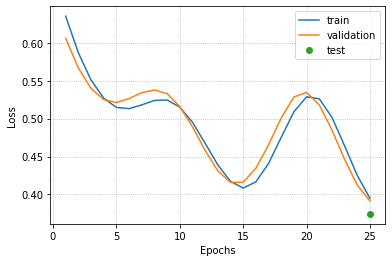

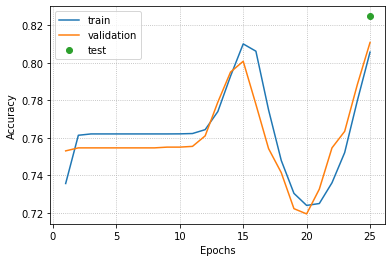

In [ ]:
metrics.append(main(dataset, mode='mlm_different', seed=1000))

epoch 0, train_loss=0.6259367316961288, validation_loss=0.5955182527884458, train_acc=0.7404285283474066, val_acc=0.7554487179487179
epoch 1, train_loss=0.5768037289381027, validation_loss=0.5579686401746212, train_acc=0.7608974969843184, val_acc=0.7538461538461538
epoch 2, train_loss=0.5423339903354645, validation_loss=0.5344777015539316, train_acc=0.7616724969843185, val_acc=0.7530448717948718
epoch 3, train_loss=0.5221342295408249, validation_loss=0.5249499388230152, train_acc=0.7616474969843184, val_acc=0.7530448717948718
epoch 4, train_loss=0.5148057490587234, validation_loss=0.5253309286557711, train_acc=0.7616724969843185, val_acc=0.7530448717948718
epoch 5, train_loss=0.5162382125854492, validation_loss=0.5315665304660797, train_acc=0.7616474969843184, val_acc=0.7530448717948718
epoch 6, train_loss=0.5195746272802353, validation_loss=0.5323899143781418, train_acc=0.7617224969843185, val_acc=0.7530448717948718
epoch 7, train_loss=0.5174190998077393, validation_loss=0.52410535934

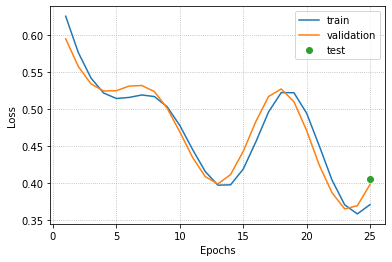

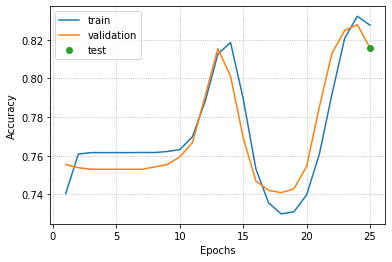

In [ ]:
metrics.append(main(dataset, mode='mlm_different', seed=10000))

In [ ]:
auc = np.array(metrics)[:, 0]
pres = np.array(metrics)[:, 1]
print('auc', np.mean(auc), np.std(auc))
print('pres', np.mean(pres), np.std(pres))

auc 0.8702763647553731 0.0015241551822701466
pres 0.8052287581699347 0.02203581846277665


# NAIVE

In [ ]:
metrics = []

epoch 0, train_loss=0.617053747177124, validation_loss=0.5973438330185719, train_acc=0.7474228890229192, val_acc=0.7508814102564103
epoch 1, train_loss=0.5757912844419479, validation_loss=0.5673088530699412, train_acc=0.7602137213510254, val_acc=0.7516826923076924
epoch 2, train_loss=0.5486182421445847, validation_loss=0.5503776356195792, train_acc=0.7604887213510252, val_acc=0.7516826923076924
epoch 3, train_loss=0.533204659819603, validation_loss=0.5427722143821228, train_acc=0.7605137213510254, val_acc=0.7516826923076924
epoch 4, train_loss=0.5262489467859268, validation_loss=0.5398280353118212, train_acc=0.7605137213510254, val_acc=0.7516826923076924
epoch 5, train_loss=0.5216215252876282, validation_loss=0.5351155339143215, train_acc=0.7605137213510254, val_acc=0.7516826923076924
epoch 6, train_loss=0.5135346949100494, validation_loss=0.5223087080014057, train_acc=0.7605387213510253, val_acc=0.7516826923076924
epoch 7, train_loss=0.497006319463253, validation_loss=0.49989512257086

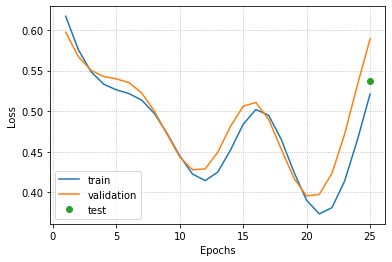

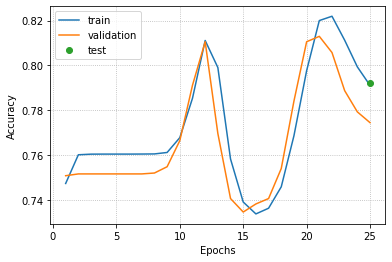

In [ ]:
metrics.append(main(dataset, mode='naive', seed=42))

epoch 0, train_loss=0.6335312277078629, validation_loss=0.5955037031418238, train_acc=0.7297435765983111, val_acc=0.7685096153846154
epoch 1, train_loss=0.5778536647558212, validation_loss=0.5493929615387549, train_acc=0.7607705367913149, val_acc=0.7669070512820513
epoch 2, train_loss=0.5399357974529266, validation_loss=0.5206000155363327, train_acc=0.7592074487334138, val_acc=0.7661057692307692
epoch 3, train_loss=0.5182593464851379, validation_loss=0.5073533906386449, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 4, train_loss=0.5110485255718231, validation_loss=0.5063771391526247, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 5, train_loss=0.5141355246305466, validation_loss=0.5121315534298236, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 6, train_loss=0.5201519727706909, validation_loss=0.5169478288063636, train_acc=0.7591197527141134, val_acc=0.7661057692307692
epoch 7, train_loss=0.521853432059288, validation_loss=0.513517010670

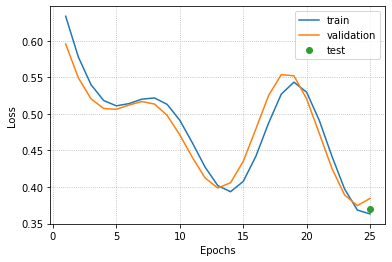

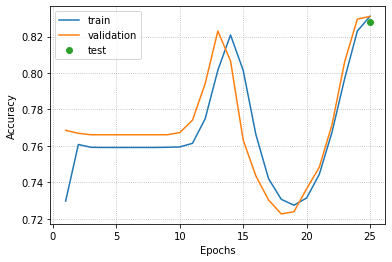

In [ ]:
metrics.append(main(dataset, mode='naive', seed=10))

epoch 0, train_loss=0.6933599561452866, validation_loss=0.6485588733966534, train_acc=0.5176240952955368, val_acc=0.7516025641025641
epoch 1, train_loss=0.629583939909935, validation_loss=0.5911817374901894, train_acc=0.7543152895054283, val_acc=0.7776442307692307
epoch 2, train_loss=0.5809490233659744, validation_loss=0.5487449765205383, train_acc=0.7619664656212304, val_acc=0.7732371794871795
epoch 3, train_loss=0.5469459593296051, validation_loss=0.5203878176517975, train_acc=0.7615914656212304, val_acc=0.7732371794871795
epoch 4, train_loss=0.5276190042495728, validation_loss=0.5068117601749225, train_acc=0.7615414656212305, val_acc=0.7732371794871795
epoch 5, train_loss=0.5218508988618851, validation_loss=0.5043681733883344, train_acc=0.7615414656212305, val_acc=0.7732371794871795
epoch 6, train_loss=0.5265852510929108, validation_loss=0.5094302407441995, train_acc=0.7615414656212305, val_acc=0.7732371794871795
epoch 7, train_loss=0.5365009009838104, validation_loss=0.517428218936

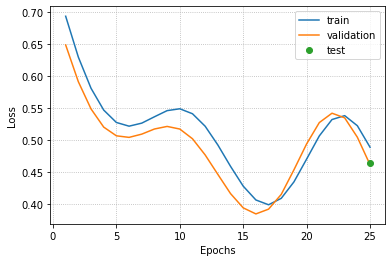

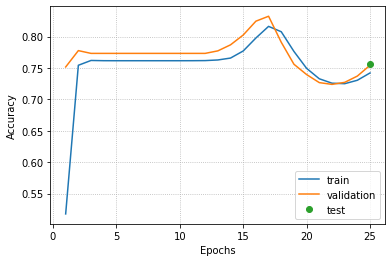

In [ ]:
metrics.append(main(dataset, mode='naive', seed=100))

epoch 0, train_loss=0.6877196580171585, validation_loss=0.6380669291202838, train_acc=0.5436557599517491, val_acc=0.7346153846153846
epoch 1, train_loss=0.6120073646306992, validation_loss=0.5785845349996518, train_acc=0.7528529855247287, val_acc=0.7546474358974359
epoch 2, train_loss=0.5584079027175903, validation_loss=0.5405166523578839, train_acc=0.762366857659831, val_acc=0.7546474358974359
epoch 3, train_loss=0.5257164984941483, validation_loss=0.5226401816575955, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 4, train_loss=0.5125203132629395, validation_loss=0.5227883962484506, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 5, train_loss=0.5155752301216125, validation_loss=0.5348019248399979, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 6, train_loss=0.5293201804161072, validation_loss=0.5535972546308469, train_acc=0.7620918576598311, val_acc=0.7546474358974359
epoch 7, train_loss=0.5454087555408478, validation_loss=0.568468843515

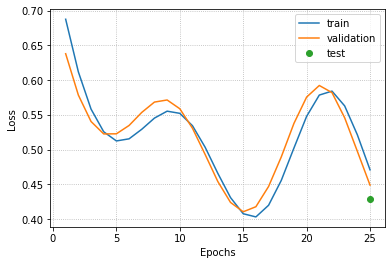

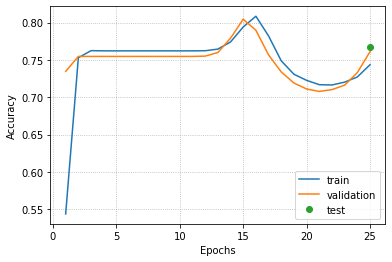

In [ ]:
metrics.append(main(dataset, mode='naive', seed=1000))

epoch 0, train_loss=0.6354319304227829, validation_loss=0.6027140311705761, train_acc=0.755839113389626, val_acc=0.7534455128205128
epoch 1, train_loss=0.584081768989563, validation_loss=0.5625099738438925, train_acc=0.7619724969843185, val_acc=0.7530448717948718
epoch 2, train_loss=0.54750095307827, validation_loss=0.5369640588760376, train_acc=0.7616224969843185, val_acc=0.7530448717948718
epoch 3, train_loss=0.5251739919185638, validation_loss=0.5250706733801426, train_acc=0.7616224969843185, val_acc=0.7530448717948718
epoch 4, train_loss=0.5160292536020279, validation_loss=0.5253413357795813, train_acc=0.7615974969843184, val_acc=0.7530448717948718
epoch 5, train_loss=0.5174922347068787, validation_loss=0.5324906997191601, train_acc=0.7615974969843184, val_acc=0.7530448717948718
epoch 6, train_loss=0.5246201306581497, validation_loss=0.541114269158779, train_acc=0.7615974969843184, val_acc=0.7530448717948718
epoch 7, train_loss=0.5303662717342377, validation_loss=0.5431063893513802

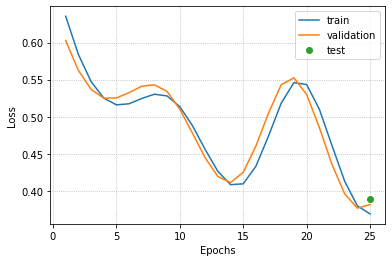

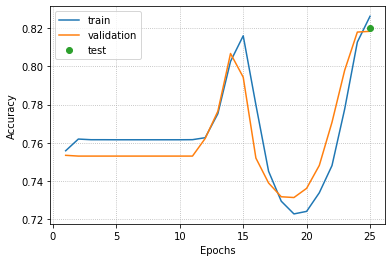

In [ ]:
metrics.append(main(dataset, mode='naive', seed=10000))

In [ ]:
auc = np.array(metrics)[:, 0]
pres = np.array(metrics)[:, 1]
print('auc', np.mean(auc), np.std(auc))
print('pres', np.mean(pres), np.std(pres))

auc 0.8693154120381619 0.006307203413379682
pres 0.792798202614379 0.028135980396502967


# ORDINARY
NaN as categ

In [ ]:
metrics = []

epoch 0, train_loss=0.6352187097072601, validation_loss=0.5973725425891387, train_acc=0.729449457177322, val_acc=0.7512820512820513
epoch 1, train_loss=0.5758004933595657, validation_loss=0.5537404387425153, train_acc=0.762115681544029, val_acc=0.7520833333333333
epoch 2, train_loss=0.5361215472221375, validation_loss=0.5293419529230167, train_acc=0.7618152895054282, val_acc=0.7520833333333333
epoch 3, train_loss=0.5160960853099823, validation_loss=0.5245774266047355, train_acc=0.7618152895054282, val_acc=0.7520833333333333
epoch 4, train_loss=0.514223650097847, validation_loss=0.5347798703572689, train_acc=0.7618152895054282, val_acc=0.7520833333333333
epoch 5, train_loss=0.5256780982017517, validation_loss=0.5529600358926333, train_acc=0.7618152895054282, val_acc=0.7520833333333333
epoch 6, train_loss=0.5412466377019882, validation_loss=0.5671560481572763, train_acc=0.7618152895054282, val_acc=0.7520833333333333
epoch 7, train_loss=0.5490804612636566, validation_loss=0.56623436472354

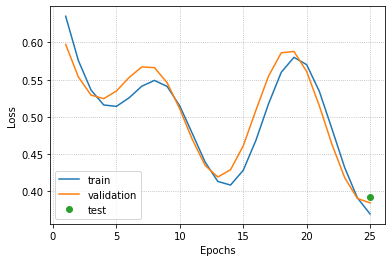

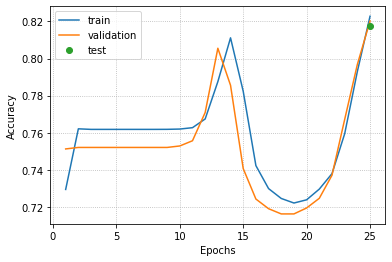

In [ ]:
metrics.append(main(dataset, mode='ordinary', seed=42))

epoch 0, train_loss=0.6096672713756561, validation_loss=0.573397043423775, train_acc=0.7444257840772015, val_acc=0.7667467948717949
epoch 1, train_loss=0.564663901925087, validation_loss=0.5367053487362006, train_acc=0.7595324487334137, val_acc=0.769150641025641
epoch 2, train_loss=0.5355838537216187, validation_loss=0.515681979747919, train_acc=0.760745144752714, val_acc=0.769551282051282
epoch 3, train_loss=0.5207761079072952, validation_loss=0.5071677840673007, train_acc=0.7608701447527141, val_acc=0.769551282051282
epoch 4, train_loss=0.5169653445482254, validation_loss=0.5066518668945019, train_acc=0.7608951447527141, val_acc=0.769551282051282
epoch 5, train_loss=0.5175881683826447, validation_loss=0.5047436891457974, train_acc=0.7609201447527141, val_acc=0.769551282051282
epoch 6, train_loss=0.5133877694606781, validation_loss=0.4939592564717317, train_acc=0.7609828407720145, val_acc=0.769551282051282
epoch 7, train_loss=0.4978218898177147, validation_loss=0.4718111829879956, tra

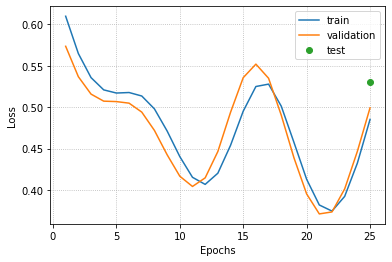

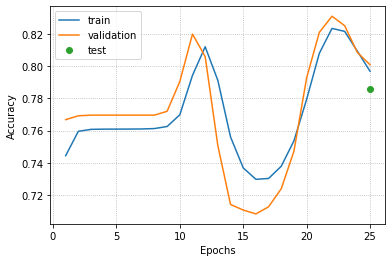

In [ ]:
metrics.append(main(dataset, mode='ordinary', seed=10))

epoch 0, train_loss=0.6393110454082489, validation_loss=0.6040741358047876, train_acc=0.7192279855247287, val_acc=0.7651442307692308
epoch 1, train_loss=0.5834270715713501, validation_loss=0.5579680739304959, train_acc=0.7662561218335344, val_acc=0.7576923076923077
epoch 2, train_loss=0.5424578934907913, validation_loss=0.5264624632321872, train_acc=0.7616549457177322, val_acc=0.7576923076923077
epoch 3, train_loss=0.5160541981458664, validation_loss=0.5105154651861924, train_acc=0.7616049457177322, val_acc=0.7576923076923077
epoch 4, train_loss=0.5045291483402252, validation_loss=0.5081987090599842, train_acc=0.7616049457177322, val_acc=0.7576923076923077
epoch 5, train_loss=0.5060284808278084, validation_loss=0.5179096231093774, train_acc=0.7616049457177322, val_acc=0.7576923076923077
epoch 6, train_loss=0.5166487544775009, validation_loss=0.5314018726348877, train_acc=0.7616049457177322, val_acc=0.7576923076923077
epoch 7, train_loss=0.5296267122030258, validation_loss=0.54274617632

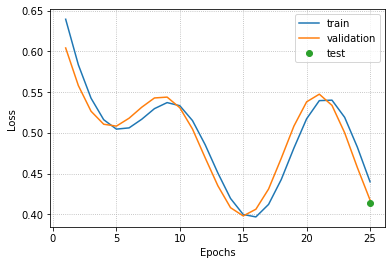

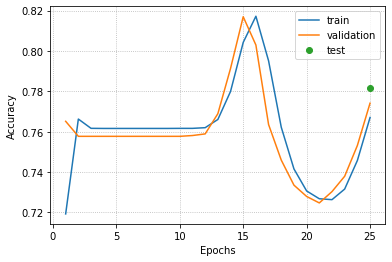

In [ ]:
metrics.append(main(dataset, mode='ordinary', seed=100))

epoch 0, train_loss=0.6358736157417297, validation_loss=0.6019932704094129, train_acc=0.7294591676718938, val_acc=0.7545673076923077
epoch 1, train_loss=0.5879101455211639, validation_loss=0.5617939004531274, train_acc=0.7586800965018095, val_acc=0.7597756410256411
epoch 2, train_loss=0.5511123389005661, validation_loss=0.5322171052296957, train_acc=0.7599677925211098, val_acc=0.7597756410256411
epoch 3, train_loss=0.525296226143837, validation_loss=0.5140330065519382, train_acc=0.7599427925211097, val_acc=0.7597756410256411
epoch 4, train_loss=0.5101060420274734, validation_loss=0.505682952893086, train_acc=0.7599427925211097, val_acc=0.7597756410256411
epoch 5, train_loss=0.5041343420743942, validation_loss=0.5044088569971231, train_acc=0.7599427925211097, val_acc=0.7597756410256411
epoch 6, train_loss=0.5041053220629692, validation_loss=0.5069267115531824, train_acc=0.7599427925211097, val_acc=0.7597756410256411
epoch 7, train_loss=0.5056381151080132, validation_loss=0.5071749817102

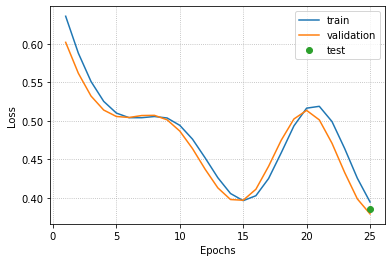

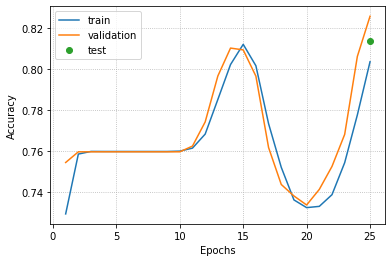

In [ ]:
metrics.append(main(dataset, mode='ordinary', seed=1000))

epoch 0, train_loss=0.6376236826181412, validation_loss=0.6063909393090469, train_acc=0.7243392641737032, val_acc=0.7446314102564102
epoch 1, train_loss=0.5829633474349976, validation_loss=0.5635655155548682, train_acc=0.7590812726176117, val_acc=0.7506410256410256
epoch 2, train_loss=0.5438245385885239, validation_loss=0.5367321570714315, train_acc=0.7606693606755126, val_acc=0.7506410256410256
epoch 3, train_loss=0.5200599282979965, validation_loss=0.5245424745938717, train_acc=0.7607066646562123, val_acc=0.7506410256410256
epoch 4, train_loss=0.5111828446388245, validation_loss=0.5266636732297066, train_acc=0.7606312726176117, val_acc=0.7506410256410256
epoch 5, train_loss=0.514411211013794, validation_loss=0.5369768601197463, train_acc=0.7605812726176115, val_acc=0.7506410256410256
epoch 6, train_loss=0.5231175869703293, validation_loss=0.5467647092464643, train_acc=0.7605812726176115, val_acc=0.7506410256410256
epoch 7, train_loss=0.5289617329835892, validation_loss=0.546821094476

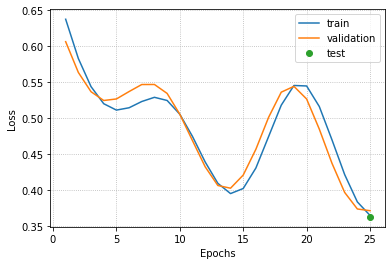

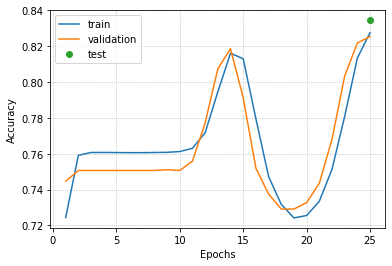

In [ ]:
metrics.append(main(dataset, mode='ordinary', seed=10000))

In [ ]:
auc = np.array(metrics)[:, 0]
pres = np.array(metrics)[:, 1]
print('auc', np.mean(auc), np.std(auc))
print('pres', np.mean(pres), np.std(pres))

auc 0.8677216549641745 0.006392371166636442
pres 0.806797385620915 0.01998417784268387
